In [1]:
# necessary libraries for pre-processing
import utils
import pandas as pd
import numpy as np
import math
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing

In [2]:
pd.set_option('display.max_columns', 200)
# pd.set_option('display.width', 1000)

## Statistical Analysis

In [3]:
def get_col_max(df, col):
    '''Get the maximum value of a given column'''
    return df[col].max()

def get_col_min(df, col):
    '''Get the minimum value of a given column'''
    return df[col].min()

def get_col_count(df, col):
    '''Get the number of elements of a given column'''
    return df[col].count()

def get_col_avg(df, col):
    '''Get the average value of a given column'''
    return df[col].mean()

def get_col_std(df, col):
    '''Get the standard deviation value of a given column'''
    return df[col].std()

def get_col_cov(df, col):
    '''Get the covariance of the given column'''
    return np.cov(df[col])

def get_cov(series):
    '''Get the covariance of the given dataseries'''
    return np.cov(series)

def get_first(df):
    '''Get the first entry of a dataframe'''
    return df.iloc[0]

# Useful functions for preprocessing

In [4]:
def convert_date(df, column, date_format='%y%m%d'):
    '''Convert the given column containg dates in the given format
    to the standard date format and type'''
    copy_df = df.copy()
    copy_df[column] = pd.to_datetime(copy_df[column], format=date_format)

    return copy_df

In [5]:
def encode_column(df, column):
    '''Encode the given column of the given dataframe.'''
    copy_df = df.copy()

    le = preprocessing.LabelEncoder()
    le.fit(df[column].unique())
    copy_df[column] = le.transform(copy_df[column])
    
    return copy_df

In [6]:
def get_df_correlation(df, size=(11, 9)):
    '''Get the correlation between the dataframe features'''
    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    # Set up the matplotlib figure
    plt.subplots(figsize=size)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    ax = sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
                     square=True, linewidths=.1, cbar_kws={"shrink": .5})
    
    y_lim = ax.get_ylim();
    ax.set_ylim(np.ceil(y_lim[0]), np.floor(y_lim[1]))

    plt.show()

In [7]:
def column_density_plot(df, col):
    '''Get a density plot for the given column in the given dataframe.
    Useful for outlier detection'''
    sns.kdeplot(df[col], shade=True)
    plt.show()

In [8]:
def column_bar_plot(df, col):
    '''Present the given feature of the given df as a barplot,
    using count as the y value'''
    col_count = '%s_count' % col
    agg_df = df.groupby([col])\
               .agg({
                   col: ['count']
               })\
               .reset_index()
    agg_df.columns = [col, col_count]
    sns.barplot(x=agg_df[col], y=agg_df[col_count], palette="rocket")
    # ax1.axhline(0, color="k", clip_on=False)
    plt.show()

In [9]:
def scatterplot_two_cols(df, col1, col2):
    '''Get a scatterplot for the given two columns'''
    # Set up the matplotlib figure
    plt.subplots(figsize=(11, 9))
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    sns.scatterplot(data=df, x=col1, y=col2,
                    hue='status',palette=cmap, sizes=(47,47))
    plt.show()

In [10]:
def bubbleplot_three_cols(df, col1, col2, col3):
    '''Bubble plot the given columns.
    Column1 is X. Column2 is Y. Column3 is hue and size'''
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.scatterplot(data=df, x=col1, y=col2,
                    hue=col3, size=col3,
                    palette=cmap, sizes=(50, 300))

    plt.show()

In [11]:
def get_features_histogram(df, figsize_val = (20, 25)):
    '''Get a histogram relating the features of the given dataframe'''
    fig = plt.figure(figsize = figsize_val)
    loan = df[df.status==1]
    do_not_loan = df[df.status==-1]
    j = 0

    for i in range(len(df.columns)):
        plt.subplot(math.ceil(len(df.columns) / 3), 3, j+1)
        j += 1
        sns.distplot(loan.iloc[:, i], color='g', label = 'loan',
                    kde = False if len(loan.iloc[:, i].unique()) is 1 else True)
        sns.distplot(do_not_loan.iloc[:, i], color='r', label = 'no loan',
                    kde = False if len(do_not_loan.iloc[:, i].unique()) is 1 else True)
        plt.legend(loc='best')

    fig.suptitle('Feature Analysis')
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    plt.show()

## Imputation

In [12]:
def get_null_summary(dataset):
    '''Get a null summary display'''
    display(dataset.isnull().mean())

In [13]:
def clean_nulls(dataset, threshold=0.7):
    '''Clean nulls from the given table.
    If the nulls in a column are higher than the given threshold the entire column is deleted.
    If the nulls in a row are higher than the row, the row is also deleted.
    The threshold is a value between 0 and 1'''
    #Dropping columns with missing value rate higher than threshold
    dataset = dataset[dataset.columns[dataset.isnull().mean() < threshold]]

    #Dropping rows with missing value rate higher than threshold
    dataset = dataset.loc[dataset.isnull().mean(axis=1) < threshold]
    
    return dataset

In [14]:
def numerical_imputation(dataset, replacer=None):
    '''When null values exist, set them using the median of the colum,
    or a replacer, if one was given'''
    dataset = dataset.fillna(replacer if replacer is not None else dataset.median())

    return dataset

In [15]:
def categorical_imputation(dataset, column_name, replacer=None):
    '''Replace the inexistent values of the given column with the given replacer.
    If None replacer was ginve, use the column maximum value'''
    #Max fill function for categorical columns
    dataset[column_name].fillna(replacer if replacer is not None else \
                                dataset[column_name].value_counts()
                                                    .idxmax(),
                                inplace=True)
    
    return dataset

## Handling Outliers

In [16]:
def display_to_drop_std(dataset, column, mult_factor=3):
    '''Display the rows that will be dropped using the std approach'''
    upper_lim = dataset[column].mean() + dataset[column].std() * mult_factor
    lower_lim = dataset[column].mean() - dataset[column].std() * mult_factor

    display(dataset[(dataset[column] >= upper_lim) & (dataset[column] <= lower_lim)])

def drop_outliers_std(dataset, column, mult_factor=3):
    '''Drop the outlier rows with standard deviation'''
    upper_lim = dataset[column].mean() + dataset[column].std() * mult_factor
    lower_lim = dataset[column].mean() - dataset[column].std() * mult_factor

    return dataset[(dataset[column] < upper_lim) & (dataset[column] > lower_lim)]

In [17]:
def display_to_drop_percentile(dataset, column):
    '''Display the rows that will be dropped with Percentiles approach'''
    upper_lim = dataset[column].quantile(.95)
    lower_lim = dataset[column].quantile(.05)

    display(dataset[(dataset[column] >= upper_lim) & (dataset[column] <= lower_lim)])

def drop_outliers_percentile(dataset, column):
    '''Drop the outlier rows with Percentiles approach'''
    upper_lim = dataset[column].quantile(.95)
    lower_lim = dataset[column].quantile(.05)

    data = dataset[(dataset[column] < upper_lim) & (dataset[column] > lower_lim)]

## Log Transform

In [18]:
def log_transform(series):
    '''Get a log_transformation of the given series'''
    min_val = series.min()
    return (series - min_val + 1).transform(np.log)

# Feature Engineering

### Load all tables to memory

In [19]:
# Loading the tables both used for train and test
account_df = utils.read_csv_to_df('competition_dataset/account.csv', delimiter=';')
disp_df = utils.read_csv_to_df('competition_dataset/disp.csv', delimiter=';')
client_df = utils.read_csv_to_df('competition_dataset/client.csv', delimiter=';')
demogra_df = utils.read_csv_to_df('competition_dataset/district.csv', delimiter=';')

# Loading the train tables
loan_df = utils.read_csv_to_df('competition_dataset/loan_train.csv', delimiter=';')
card_df = utils.read_csv_to_df('competition_dataset/card_train.csv', delimiter=';')
trans_df = utils.read_csv_to_df('competition_dataset/trans_train.csv', delimiter=';')

# Loading the test tables
loan_test_df = utils.read_csv_to_df('competition_dataset/loan_test.csv', delimiter=';')
card_test_df = pd.concat([utils.read_csv_to_df('competition_dataset/card_test.csv', delimiter=';'),
                          card_df])
trans_test_df = pd.concat([utils.read_csv_to_df('competition_dataset/trans_test.csv', delimiter=';'),
                            trans_df])

print(' ::: Tables Scheme :::')
print('\n\n\t LOAN TABLE')
display(loan_df.head())
print('\n\n\t ACCOUNT TABLE')
display(account_df.head())
print('\n\n\t DISPOSITION TABLE')
display(disp_df.head())
print('\n\n\t CREDIT CARD TABLE')
display(card_df.head())
print('\n\n\t CLIENT TABLE')
display(client_df.head())
print('\n\n\tTRANSACTIONS TABLE')
display(trans_df.head())
print('\n\n\tDEMOGRAPHIC TABLE')
display(demogra_df.head())

 ::: Tables Scheme :::


	 LOAN TABLE


/Users/edgarcarneiro/Documents/University/feup-ecac/project-competition/env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


,loan_id,account_id,date,amount,duration,payments,status
0,5314,1787,930705,96396,12,8033,-1
1,5316,1801,930711,165960,36,4610,1
2,6863,9188,930728,127080,60,2118,1
3,5325,1843,930803,105804,36,2939,1
4,7240,11013,930906,274740,60,4579,1




	 ACCOUNT TABLE


,account_id,district_id,frequency,date
0,576,55,monthly issuance,930101
1,3818,74,monthly issuance,930101
2,704,55,monthly issuance,930101
3,2378,16,monthly issuance,930101
4,2632,24,monthly issuance,930102




	 DISPOSITION TABLE


,disp_id,client_id,account_id,type
0,1,1,1,OWNER
1,2,2,2,OWNER
2,3,3,2,DISPONENT
3,4,4,3,OWNER
4,5,5,3,DISPONENT




	 CREDIT CARD TABLE


,card_id,disp_id,type,issued
0,1005,9285,classic,931107
1,104,588,classic,940119
2,747,4915,classic,940205
3,70,439,classic,940208
4,577,3687,classic,940215




	 CLIENT TABLE


,client_id,birth_number,district_id
0,1,706213,18
1,2,450204,1
2,3,406009,1
3,4,561201,5
4,5,605703,5




	TRANSACTIONS TABLE


,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,1548749,5270,930113,credit,credit in cash,800.0,800.0,NaN,NaN,NaN
1,1548750,5270,930114,credit,collection from another bank,44749.0,45549.0,NaN,IJ,80269753.0
2,3393738,11265,930114,credit,credit in cash,1000.0,1000.0,NaN,NaN,NaN
3,3122924,10364,930117,credit,credit in cash,1100.0,1100.0,NaN,NaN,NaN
4,1121963,3834,930119,credit,credit in cash,700.0,700.0,NaN,NaN,NaN




	DEMOGRAPHIC TABLE


,code,name,region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate '95,unemploymant rate '96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674
2,3,Beroun,central Bohemia,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813
3,4,Kladno,central Bohemia,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892
4,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040


# Individual pre processement of tables

In [20]:
def process_loans(loans_df, debug=False):
    '''Pre process the loan table'''
    if debug:
        print(' > Raw loan table representation')
        display(loans_df)
        print(' > Raw loan table correlations')
        get_df_correlation(loans_df)
        
    processed_df = convert_date(loans_df, 'date')
    
    # As there is a correlation between amount, duration & payments
    if debug:
        print(' > There is naturally a correlation between the amount, duration and payments columns,'+
              'since amount = columns * payments')
        scatterplot_two_cols(processed_df, 'amount', 'duration')
        scatterplot_two_cols(processed_df, 'amount', 'payments')
        print(' > Natural correlations, since the larger the amount the larger the monthly payment or the duration.')
        
        print(' > We can also use this correlation to inquiry if there is bank interest rate:')
        processed_df['payment_duration'] = processed_df['duration'] * processed_df['payments']
        scatterplot_two_cols(processed_df, 'amount', 'payment_duration')

        processed_df = processed_df.drop(['payment_duration'], axis=1)
        
    # No User has a history of loanning, at least in the train dataset
    # Since amount = payments * duration we can conclude that there is no interest rate to the bank
        
    return processed_df

In [21]:
def process_account(accounts_df, debug=False):
    '''Pre process the accounts table'''
    if debug:
        print(' > Raw accounts table representation')
        display(accounts_df)
        print(' > Raw accounts table correlations')
        get_df_correlation(accounts_df)
        
    processed_account = convert_date(account_df, 'date')
    
    # Encode categorical column
    df = encode_column(processed_account, 'frequency')
        
    if debug:
        print(' > Lets encode the frequency column:')
        display(df)
        print(' > And the features correlation:')
        get_df_correlation(df)

    return df

In [22]:
def process_dispostition(disp_df, debug=False):
    '''Pre process the dispositions table'''
    if debug:
        print(' > Raw disposition table representation')
        display(disp_df)
        print(' > Raw disposition table correlations')
        get_df_correlation(disp_df)
        
    processed_disp = disp_df.copy()
    
    # Renaming disp attributes
    processed_disp.loc[processed_disp["type"]=="OWNER","type"] = "O"
    processed_disp.loc[processed_disp["type"]=="DISPONENT","type"] = "U"
    
    # Transform numerical into categorical
    df = pd.get_dummies(processed_disp)
    
    if debug:
        print(' > Transformed the categorical type column into numerical respective columns')
        display(df)
        print(' > Since the 2 categories are depedent, we can remove one of them, for removing redundant data')
        get_df_correlation(df)
        
    # Cannot process further as needs merging with other columns
    return df

In [23]:
def process_card(card_df, debug=False):
    '''Pre process the credit card table'''
    if debug:
        print(' > Raw credit card table representation')
        display(card_df)
        print(' > Raw credit card table correlations')
        get_df_correlation(card_df)

    processed_card = convert_date(card_df, 'issued')
    if debug:
        print(' > The distribution of type of cards per client:')
        column_bar_plot(processed_card, 'type')

    df = encode_column(processed_card, 'type')
    df = df.drop(['card_id'], axis=1)
    
    if debug:
        print(' > Encoded the type column:')
        display(df)
        
    # Cannot process further as needs merging with other columns
    return df

In [24]:
def process_client(client_df, debug=False):
    '''Pre process the client table'''
    if debug:
        print(' > Raw client table representation')
        display(client_df)
        print(' > Raw client table correlations')
        get_df_correlation(client_df)
        
    processed_df = client_df.copy()
        
    # Getting year, day, and month+50 if women
    processed_df['year'] = 1900 + (processed_df['birth_number'] // 10000)
    processed_df['month_gender'] = (processed_df['birth_number'] % 10000) // 100
    processed_df['day'] = processed_df['birth_number'] % 100

    # Extracting gender and month
    processed_df['gender'] = np.where(processed_df['month_gender']>=50, 1, 0)
    processed_df['month'] = np.where(processed_df['month_gender']>=50, processed_df['month_gender']-50, processed_df['month_gender'])

    # Composing data
    processed_df['birth_date'] = processed_df['year'] * 10000 +\
                                 processed_df['month'] * 100 +\
                                 processed_df['day']
    df = convert_date(processed_df, 'birth_date', '%Y%m%d')
    
    # Dropping useless columns
    df = df.drop(['birth_number', 'year', 'month_gender', 'month', 'day'], axis=1)
    
    if debug:
        print(' > After extracting the gender from the date we have:')
        display(df)
        print(' > Notice the gender representation:\n\t * 1 if female\n\t * 0 if male')
        get_df_correlation(df)
    
    return df

In [25]:
def process_transactions(transactions_df, debug=False):
    '''Pre process the transactions table'''
    if debug:
        print(' > Raw transactions table representation')
        display(transactions_df)
        print(' > Raw transactions table correlations')
        get_df_correlation(transactions_df)
        
    if debug:
        print(' > Null evaluation in transactions rows')
        get_null_summary(transactions_df)
        
    # Removing the null columns & processing data
    processed_df = clean_nulls(transactions_df)
    processed_df = convert_date(processed_df, 'date')
    
    # Filling null columns with too much nulls
    processed_df = categorical_imputation(processed_df, 'k_symbol', ' ')
    
    if debug:
        print(' > Type of operations on Transactions:')
        display(processed_df['operation'].unique())
        print(' > Type of k_symbol on Transactions:')
        display(processed_df['k_symbol'].unique())
    
    # Renaming 'withdrawal in cash' to 'withdrawal'
    processed_df.loc[processed_df["type"]=="withdrawal in cash","type"] = "withdrawal"

    # Renaming of operations
    processed_df.loc[processed_df["operation"]=="credit in cash", "operation"] = "CC"
    processed_df.loc[processed_df["operation"]=="collection from another bank", "operation"] = "CAB"
    processed_df.loc[processed_df["operation"]=="withdrawal in cash", "operation"] = "WC"
    processed_df.loc[processed_df["operation"]=="remittance to another bank", "operation"] = "RAB"
    processed_df.loc[processed_df["operation"]=="credit card withdrawal", "operation"] = "CCW"
    processed_df = categorical_imputation(processed_df, 'operation', 'IC') # Interest credited
    
    # Making withdrawals amount negatives
    processed_df.loc[processed_df["type"]=="withdrawal", "amount"] *=-1 
    
    if debug:
        print(' > Dataframe after renamings & deletion of empty columns')
        display(processed_df)
        display(processed_df['operation'].unique())
    
    # Aggregatting transaction balances
    agg_ballance = processed_df.sort_values(by=['account_id', 'date'],
                                            ascending=[True, False])\
                               .groupby(['account_id'])\
                               .agg({
                                    'balance': ['mean', 'max', 'min', 'std', get_first],
                                    'date': get_first,
                                    'amount': get_first
                               })\
                               .reset_index()
    agg_ballance.columns = ['account_id', 'balance_mean', 'balance_max', 'balance_min', 'balance_std',
                            'last_balance', 'last_trans_date', 'last_trans']
    agg_ballance['reached_negative_balance'] = agg_ballance['balance_min']
    agg_ballance.loc[agg_ballance["balance_min"] >= 0, "reached_negative_balance"] = 1
    agg_ballance.loc[agg_ballance["balance_min"] < 0, "reached_negative_balance"] = -1

    # Agrregatting credits &. withdrawals
    agg_types = processed_df.sort_values(by=['account_id', 'date'],
                                            ascending=[True, False])\
                              .groupby(['account_id', 'type'])\
                              .agg({
                                  'amount': ['mean', 'count', 'max', 'min', 'std'],
                              })\
                              .reset_index()
    agg_types.columns = ['account_id', 'type', 'type_mean', 'type_count',
                           'type_max', 'type_min', 'type_std']

    agg_credits = agg_types[agg_types['type'] == 'credit']
    agg_credits.columns = ['account_id', 'type', 'credit_mean', 'credit_count',
                           'credit_max', 'credit_min', 'credit_std']
    agg_credits.drop(['type'], axis=1)
    
    agg_withdrawals = agg_types[agg_types['type'] == 'withdrawal']
    agg_withdrawals.columns = ['account_id', 'type', 'withdrawal_mean', 'withdrawal_count',
                           'withdrawal_max', 'withdrawal_min', 'withdrawal_std']
    agg_withdrawals.drop(['type'], axis=1)
    
    # Aggregatting k_symbols
    agg_k_symbol = processed_df.groupby(['account_id', 'k_symbol'])\
                           .agg({
                               'amount': ['mean', 'sum', 'count', 'std']
                           })\
                           .reset_index()
    agg_k_symbol.columns = ['account_id', 'k_symbol', 'amount_mean',
                            'amount_sum', 'amount_count', 'amount_std']

    
    # Geetting households - only mean is interesting
    households = agg_k_symbol[agg_k_symbol['k_symbol'] == 'household']
    households.columns = ['account_id', 'k_symbol', 'household', '_1', '_2', '_3']
    households = households.drop(['k_symbol', '_1', '_2', '_3'], axis=1)
    
    # Geetting pensions - only mean is interesting
    pensions = agg_k_symbol[agg_k_symbol['k_symbol'] == 'old-age pension']
    pensions.columns = ['account_id', 'k_symbol', 'pension', '_1', '_2', '_3']
    pensions = pensions.drop(['k_symbol', '_1', '_2', '_3'], axis=1)
    
    # Geetting unknown stats
    unknown = agg_k_symbol[agg_k_symbol['k_symbol'] == ' ']
    unknown.columns = ['account_id', 'k_symbol', 'unknown_mean', 'unknown_sum', 'unknown_count', 'unknown_std']
    unknown = unknown.drop(['k_symbol'], axis=1)

    # Gettting payments for statement stats
    payment_st = agg_k_symbol[agg_k_symbol['k_symbol'] == 'payment for statement']
    payment_st.columns = ['account_id', 'k_symbol', 'payment_statement_mean', 'payment_statement_sum',
                        'payment_statement_count', '_2']
    payment_st = payment_st.drop(['k_symbol', '_2'], axis=1)
    
    # Getting insurance payment stats
    ins_payment = agg_k_symbol[agg_k_symbol['k_symbol'] == 'insurrance payment']
    ins_payment.columns = ['account_id', 'k_symbol', 'ins_payment_mean', 'ins_payment_sum',
                        'ins_payment_count', '_2']
    ins_payment = ins_payment.drop(['k_symbol', '_2'], axis=1)
    
    # Getting insurance payment stats
    sanctions = agg_k_symbol[agg_k_symbol['k_symbol'] == 'sanction interest if negative balance']
    sanctions.columns = ['account_id', 'k_symbol', 'sanctions_mean', 'sanctions_sum',
                        'sanctions_count', 'sanctions_std']
    sanctions = sanctions.drop(['k_symbol'], axis=1)

    # Aggregatting all the 5 tables into one - agg_ballance, agg_credits, agg_withdrawals, households & pensions
    df = agg_ballance.merge(agg_credits, on='account_id', how='left')\
                     .merge(agg_withdrawals, on='account_id', how='left')\
                     .merge(households, on='account_id', how='left')\
                     .merge(pensions, on='account_id', how='left')\
                     .merge(unknown, on='account_id', how='left')\
                     .merge(payment_st, on='account_id', how='left')\
                     .merge(ins_payment, on='account_id', how='left')\
                     .merge(sanctions, on='account_id', how='left')

    
    # Cleaning nulls
    df = df.drop(['type_x', 'type_y'], axis=1)
    df = numerical_imputation(df, 0)

    
    # Cleaning nulls and performing aggreggation on table containing operations
    operations = processed_df.groupby(['account_id', 'operation'])\
                             .agg({
                                 'amount': ['count', 'mean', 'sum', 'max', 'std', 'min'],
                             })\
                             .reset_index()
    operations.columns = ['account_id', 'operation', 'amount_count', 'amount_mean', 'amount_sum',
                          'amount_max', 'amount_std', 'amount_min']
    
    # Getting CC
    cc = operations[operations['operation'] == 'CC']
    cc.columns = ['account_id', 'operation', 'CC', 'CC_mean', 'CC_sum', 'CC_max', 'CC_std', 'CC_min']
    cc = cc.drop(['operation'], axis=1)
    
    # Getting CAB
    cab = operations[operations['operation'] == 'CAB']
    cab.columns = ['account_id', 'operation', 'CAB', 'CAB_mean', 'CAB_sum', 'CAB_max', 'CAB_std', 'CAB_min']
    cab =cab.drop(['operation'], axis=1)
    
    # Getting IC
    ic = operations[operations['operation'] == 'IC']
    ic.columns = ['account_id', 'operation', 'IC', 'IC_mean', 'IC_sum', 'IC_max', 'IC_std', 'IC_min']
    ic = ic.drop(['operation'], axis=1)
    
    # Getting WC
    wc = operations[operations['operation'] == 'WC']
    wc.columns = ['account_id', 'operation', 'WC', 'WC_mean', 'WC_sum', 'WC_max', 'WC_std', 'WC_min']
    wc = wc.drop(['operation'], axis=1)
    
    # Getting RAB
    rab = operations[operations['operation'] == 'RAB']
    rab.columns = ['account_id', 'operation', 'RAB', 'RAB_mean', 'RAB_sum', 'RAB_max', 'RAB_std', 'RAB_min']
    rab = rab.drop(['operation'], axis=1)
    
    # Getting CCW
    ccw = operations[operations['operation'] == 'CCW']
    ccw.columns = ['account_id', 'operation', 'CCW', 'CCW_mean', 'CCW_sum', 'CCW_max', 'CCW_std', 'CCW_min']
    ccw = ccw.drop(['operation'], axis=1)
    
    # Joining all the operations
    operations_df = cc.merge(cab, on='account_id', how='left')\
                      .merge(ic, on='account_id', how='left')\
                      .merge(wc, on='account_id', how='left')\
                      .merge(rab, on='account_id', how='left')\
                      .merge(ccw, on='account_id', how='left')
    # Cleaning nulls
    operations_df = numerical_imputation(operations_df, 0)
    
    if debug:
        print(' > We can also compute the type operations for each account, and the respective statistics:')
        display(operations_df)
        
    # Join operations with the numeric data
    df = df.merge(operations_df, on='account_id', how='left')
    
    # Adding extra columns
    df['mean_trans_profit'] = df['credit_mean'] + df['withdrawal_mean']
    df['total_ops'] = df['CC'] + df['CAB'] + df['WC'] + df['RAB'] + df['CCW'] + df['IC']
    df['credit_ratio'] = df['credit_count'] / df['total_ops']
    df['withdrawal_ratio'] = df['withdrawal_count'] / df['total_ops']
    df['balance_range'] = df['balance_max'] - df['balance_min']

    # OPs as ratios
    df['ratio_CC'] = df['CC'] / df['total_ops']
    df['ratio_CAB'] = df['CAB'] / df['total_ops']
    df['ratio_WC'] = df['WC'] / df['total_ops']
    df['ratio_RAB'] = df['RAB'] / df['total_ops']
    df['ratio_CCW'] = df['CCW'] / df['total_ops']
    df['ratio_IC'] = df['IC'] / df['total_ops']

    # df = df.drop(['CC', 'CAB', 'WC', 'RAB', 'CCW', 'IC', 'credit_count', 'withdrawal_count'], axis=1)

    if debug:
        print(' > Table after processment of balance, credits, withdrawals, households, pensions and operations')
        display(df)
        get_null_summary(df)
        print(' > And the corresponding correlation matrix')
        get_df_correlation(df)
    
    return df

In [26]:
def process_demographic(demographic_df, debug=False):
    '''Pre process the demographic table'''
    if debug:
        print(' > Raw demographic table representation')
        display(demographic_df)
        print(' > Raw demographic table correlations')
        get_df_correlation(demographic_df)
        
    if debug:
        print(' > Null evaluation in demographic rows')
        get_null_summary(demographic_df)
        
    if debug:
        print(' > Lets see the impact of urbanization on salaries')
        bubbleplot_three_cols(demographic_df, 'no. of inhabitants',
                              'ratio of urban inhabitants ', 'average salary ')
    
    # Encode categorical columns
    df = encode_column(demographic_df, 'name ')
    df = encode_column(df, 'region')
    
    if debug:
        print('First, lets start by encoding the categorical columns')
        display(df)
        display(df.columns)

    # Replacing '?' by the average value
    median_crimes_95 = pd.to_numeric(df[df['no. of commited crimes \'95 '] != '?']\
                                     ['no. of commited crimes \'95 ']).median()
    df.loc[df['no. of commited crimes \'95 ']=="?", 'no. of commited crimes \'95 '] = median_crimes_95

    median_unemploymant_95 = (df[df['unemploymant rate \'95 '] != '?']\
                              ['unemploymant rate \'95 ']).astype(float).median()
    df.loc[df['unemploymant rate \'95 ']=="?", 'unemploymant rate \'95 '] = median_unemploymant_95
    
    # Transforming data to ints/ floats
    df['unemploymant rate \'95 '] = df['unemploymant rate \'95 '].astype(float)
    df['no. of commited crimes \'95 '] = pd.to_numeric(df['no. of commited crimes \'95 '])
    df['unemploymant rate \'96 '] = df['unemploymant rate \'96 '].astype(float)
    df['no. of commited crimes \'96 '] = pd.to_numeric(df['no. of commited crimes \'96 '])
    df['no. of enterpreneurs per 1000 inhabitants '] = pd.to_numeric(df['no. of enterpreneurs per 1000 inhabitants '])
    df['ratio of urban inhabitants '] = df['ratio of urban inhabitants '].astype(float)

    # Now lets create new features:
    df['ratio entrepeneurs'] = df['no. of enterpreneurs per 1000 inhabitants '] / 1000
    df['ratio of urban inhabitants '] = df['ratio of urban inhabitants '] / 100
    
    # Growths
    df['criminality_growth'] = (df['no. of commited crimes \'96 '] - df['no. of commited crimes \'95 ']) /\
                              df['no. of inhabitants']
    df['unemploymant_growth'] = df['unemploymant rate \'96 '] - df['unemploymant rate \'95 ']
    
    df = df.drop(['no. of enterpreneurs per 1000 inhabitants ', 
                 'unemploymant rate \'96 ', 'no. of commited crimes \'96 ',
                  'unemploymant rate \'95 ', 'no. of commited crimes \'95 '], axis=1)
    
    if debug:
        print('The final demographic plot, with additional features and having converted some features to ratios:')
        display(df)
        print('And the corresponding correlation matrix:')
        get_df_correlation(df)

    return df.rename(columns={'code ': 'district_id'}).drop(['name '], axis=1)

# Composite pre processment of tables

 > Joint table of loans, account, transaction:


,loan_id,account_id,date,amount,duration,payments,status,frequency,account_creation_date,balance_mean,balance_max,balance_min,balance_std,last_balance,last_trans_date,last_trans,reached_negative_balance,credit_mean,credit_count,credit_max,credit_min,credit_std,withdrawal_mean,withdrawal_count,withdrawal_max,withdrawal_min,withdrawal_std,household,pension,unknown_mean,unknown_sum,unknown_count,unknown_std,payment_statement_mean,payment_statement_sum,payment_statement_count,ins_payment_mean,ins_payment_sum,ins_payment_count,sanctions_mean,sanctions_sum,sanctions_count,sanctions_std,CC,CC_mean,CC_sum,CC_max,CC_std,CC_min,CAB,CAB_mean,CAB_sum,CAB_max,CAB_std,CAB_min,IC,IC_mean,IC_sum,IC_max,IC_std,IC_min,WC,WC_mean,WC_sum,WC_max,WC_std,WC_min,RAB,RAB_mean,RAB_sum,RAB_max,RAB_std,RAB_min,CCW,CCW_mean,CCW_sum,CCW_max,CCW_std,CCW_min,mean_trans_profit,total_ops,credit_ratio,withdrawal_ratio,balance_range,ratio_CC,ratio_CAB,ratio_WC,ratio_RAB,ratio_CCW,ratio_IC
0,5314,1787,1993-07-05,96396,12,8033,-1,2,1993-03-22,12250.000000,20100.0,1100.0,8330.866301,20100.0,1993-06-20,3300.0,1.0,5025.000000,4,9900.0,1100.0,3774.806838,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,5025.000000,20100.0,4,3774.806838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,5025.000000,20100.0,9900.0,3774.806838,1100.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5025.000000,4.0,1.000000,0.000000,19000.0,1.000000,0.000000,0.000000,0.000000,0.0,0.000000
1,5316,1801,1993-07-11,165960,36,4610,1,1,1993-02-13,52083.859459,120512.8,700.0,29122.059454,52208.9,1993-07-09,-3419.0,1.0,13523.158824,17,36574.0,2.9,13998.092225,-8884.240000,20.0,-14.6,-54300.0,14074.800608,-4167.0,0.0,2608.833333,62612.0,24,22249.103350,-14.6,-43.8,3.0,-956.0,-2868.0,3.0,0.0,0.0,0.0,0.0,12,19087.583333,229051.0,36574.0,13044.711945,700.0,0.0,0.000000,0.0,0.0,0.000000,0.0,5.0,168.540000,842.7,303.4,114.790213,2.9,12.0,-13018.816667,-156225.8,-14.6,17151.944816,-54300.0,8.0,-2682.375000,-21459.0,-956.0,1462.736373,-4167.0,0.0,0.0,0.0,0.0,0.0,0.0,4638.918824,37.0,0.459459,0.540541,119812.8,0.324324,0.000000,0.324324,0.216216,0.0,0.135135
2,6863,9188,1993-07-28,127080,60,2118,1,1,1993-02-08,30060.954167,49590.4,800.0,11520.184451,20272.8,1993-07-21,-12000.0,1.0,5009.733333,15,19065.0,48.6,6801.234716,-6097.000000,9.0,-66.0,-14800.0,5390.565972,-7936.0,0.0,1966.714286,27534.0,14,10647.755108,0.0,0.0,0.0,-66.0,-66.0,1.0,0.0,0.0,0.0,0.0,2,2250.000000,4500.0,3700.0,2050.609665,800.0,5.0,13981.000000,69905.0,19065.0,2842.042399,12710.0,8.0,92.625000,741.0,139.8,32.231872,48.6,6.0,-7733.333333,-46400.0,-1700.0,5385.041009,-14800.0,3.0,-2824.333333,-8473.0,-66.0,4431.462324,-7936.0,0.0,0.0,0.0,0.0,0.0,0.0,-1087.266667,24.0,0.625000,0.375000,48790.4,0.083333,0.208333,0.250000,0.125000,0.0,0.333333
3,5325,1843,1993-08-03,105804,36,2939,1,1,1993-01-30,41297.480000,65898.5,1000.0,14151.260443,34307.3,1993-07-31,178.1,1.0,9254.600000,13,26448.0,132.8,9818.591218,-7168.100000,12.0,-14.6,-15600.0,4919.096434,-6994.0,0.0,2969.250000,47508.0,16,13937.959427,-14.6,-29.2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2450.000000,4900.0,3900.0,2050.609665,1000.0,6.0,19101.333333,114608.0,26448.0,3599.116929,17632.0,5.0,160.360000,801.8,201.3,29.481231,132.8,10.0,-7202.920000,-72029.2,-14.6,5437.522527,-15600.0,2.0,-6994.000000,-13988.0,-6994.0,0.000000,-6994.0,0.0,0.0,0.0,0.0,0.0,0.0,2086.500000,25.0,0.520000,0.480000,64898.5,0.080000,0.240000,0.400000,0.080000,0.0,0.200000
4,7240,11013,1993-09-06,274740,60,4579,1,2,1993-02-14,57188.211111,122893.1,600.0,25256.665817,41112.9,1993-08-31,-30.0,1.0,21255.930769,13,63366.0,77.1,24264.229780,-16801.000000,14.0,-30.0,-36700.0,13981.924936,-756.0,0.0,2266.000000,40788.0,18,33727.841554,-30.0,-60.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,600.000000,600.0,600.0,0.000000,600.0,6.0,45764.333333,274586.0,63366.0,8623.020391,42244.0,6.0,190.183333,1141.1,254.8,61.991271,77.1,11.0,-19587.272727,-2

 > Joint table of disposition, client & card:


,disp_id,client_id,account_id,type_O,type_U,district_id,gender,birth_date,type,issued
0,1,1,1,1,0,18,1,1970-12-13,NaN,NaT
1,2,2,2,1,0,1,0,1945-02-04,NaN,NaT
2,3,3,2,0,1,1,1,1940-10-09,NaN,NaT
3,4,4,3,1,0,5,0,1956-12-01,NaN,NaT
4,5,5,3,0,1,5,1,1960-07-03,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...
5364,13647,13955,11349,1,0,1,1,1945-10-30,NaN,NaT
5365,13648,13956,11349,0,1,1,0,1943-04-06,NaN,NaT
5366,13660,13968,11359,1,0,61,0,1968-04-13,0.0,1995-06-13
5367,13663,13971,11362,1,0,67,1,1962-10-19,NaN,NaT


disp_id        0.000000
client_id      0.000000
account_id     0.000000
type_O         0.000000
type_U         0.000000
district_id    0.000000
gender         0.000000
birth_date     0.000000
type           0.967033
issued         0.967033
dtype: float64

 > Table after aggreggating data by account_id:


,account_id,owner_count,disponent_count,owner_gender,owner_birthdate,district_id,card_type,has_card
0,1,1,1,1,1970-12-13,18,-1.0,-1.0
1,2,2,2,0,1945-02-04,1,-1.0,-1.0
2,3,2,2,0,1956-12-01,5,-1.0,-1.0
3,4,1,1,0,1919-09-22,12,-1.0,-1.0
4,5,1,1,0,1929-01-25,15,-1.0,-1.0
...,...,...,...,...,...,...,...,...
4495,11333,1,1,0,1942-01-01,8,-1.0,-1.0
4496,11349,2,2,1,1945-10-30,1,-1.0,-1.0
4497,11359,1,1,0,1968-04-13,61,0.0,-1.0
4498,11362,1,1,1,1962-10-19,67,-1.0,-1.0


 > Table after joining with the demographics table:


,account_id,owner_count,disponent_count,owner_gender,owner_birthdate,district_id,card_type,has_card,region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,ratio entrepeneurs,criminality_growth,unemploymant_growth
0,1,1,1,1,1970-12-13,18,-1.0,-1.0,5,70699,60,13,2,1,4,0.653,8968,0.131,0.002405,0.52
1,343,1,1,0,1978-03-13,18,-1.0,-1.0,5,70699,60,13,2,1,4,0.653,8968,0.131,0.002405,0.52
2,413,1,1,1,1935-07-08,18,-1.0,-1.0,5,70699,60,13,2,1,4,0.653,8968,0.131,0.002405,0.52
3,431,1,1,0,1980-04-13,18,-1.0,-1.0,5,70699,60,13,2,1,4,0.653,8968,0.131,0.002405,0.52
4,568,1,1,0,1979-10-21,18,-1.0,-1.0,5,70699,60,13,2,1,4,0.653,8968,0.131,0.002405,0.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,7990,1,1,1,1967-03-17,9,-1.0,-1.0,1,81344,61,23,4,2,6,0.553,8899,0.149,-0.006147,0.58
4496,8039,1,1,0,1972-06-23,9,-1.0,-1.0,1,81344,61,23,4,2,6,0.553,8899,0.149,-0.006147,0.58
4497,8153,1,1,0,1974-04-23,9,-1.0,-1.0,1,81344,61,23,4,2,6,0.553,8899,0.149,-0.006147,0.58
4498,9153,2,2,0,1938-09-25,9,-1.0,-1.0,1,81344,61,23,4,2,6,0.553,8899,0.149,-0.006147,0.58


 > Obtained dataframe after joining the previous tables and doing some feature engineering over them


,loan_id,date,amount,payments,status,frequency,account_creation_date,balance_mean,balance_max,balance_min,balance_std,last_balance,last_trans_date,last_trans,reached_negative_balance,credit_mean,credit_count,credit_max,credit_min,credit_std,withdrawal_mean,withdrawal_count,withdrawal_max,withdrawal_min,withdrawal_std,unknown_mean,unknown_sum,unknown_count,unknown_std,payment_statement_mean,payment_statement_sum,payment_statement_count,ins_payment_mean,ins_payment_sum,ins_payment_count,sanctions_mean,sanctions_sum,sanctions_count,sanctions_std,CC,CC_mean,CC_sum,CC_max,CC_std,CC_min,CAB,CAB_mean,CAB_sum,CAB_max,CAB_std,CAB_min,IC,IC_mean,IC_sum,IC_max,IC_std,IC_min,WC,WC_mean,WC_sum,WC_max,WC_std,WC_min,RAB,RAB_mean,RAB_sum,RAB_max,RAB_std,RAB_min,CCW,CCW_mean,CCW_sum,CCW_max,CCW_std,CCW_min,mean_trans_profit,total_ops,credit_ratio,withdrawal_ratio,balance_range,ratio_CC,ratio_CAB,ratio_WC,ratio_RAB,ratio_CCW,ratio_IC,owner_count,disponent_count,owner_gender,card_type,has_card,region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,ratio entrepeneurs,criminality_growth,unemploymant_growth,account_age_on_loan,days_since_last_transaction,owner_age_on_loan,max_value_in_account_to_loan_ratio,last_value_in_account_to_loan_ratio,account_age_months,trans_per_month,credit_per_month,withdrawal_per_month,salary_from_month_records,withdrawal_to_credit_month_ratio,expected_month_income,actual_month_income,expected_income_to_payments_ratio,actual_income_to_payments_ratio,ratio_actual_salary_to_expected,log_credit_min,log_sanctions_std,log_CAB_sum,log_CAB_mean,log_max_value_in_account_to_loan_ratio,log_criminality_growth
0,5314,741830400000000000,96396,8033,-1,2,1993-03-22,12250.000000,20100.0,1100.0,8330.866301,20100.0,1993-06-20,3300.0,1.0,5025.000000,4,9900.0,1100.0,3774.806838,0.000000,0.0,0.0,0.0,0.000000,5025.000000,20100.0,4,3774.806838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,5025.000000,20100.0,9900.0,3774.806838,1100.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5025.000000,4.0,1.000000,0.000000,19000.0,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,1,1,1,-1.0,-1.0,7,94812,15,13,8,2,10,0.818,9650,0.100,-0.001909,0.29,105,15,45.986301,0.208515,0.208515,3.500000,1.142857,1435.714286,0.000000,5025.000000,0.000000,804.166667,5025.000000,0.100108,0.625545,6.248705,7.003247,0.0,0.000000,0.000000,0.113178,0.034255
1,5316,742348800000000000,165960,4610,1,1,1993-02-13,52083.859459,120512.8,700.0,29122.059454,52208.9,1993-07-09,-3419.0,1.0,13523.158824,17,36574.0,2.9,13998.092225,-8884.240000,20.0,-14.6,-54300.0,14074.800608,2608.833333,62612.0,24,22249.103350,-14.6,-43.8,3.0,-956.0,-2868.0,3.0,0.0,0.0,0.0,0.0,12,19087.583333,229051.0,36574.0,13044.711945,700.0,0.0,0.000000,0.0,0.0,0.000000,0.0,5.0,168.540000,842.7,303.4,114.790213,2.9,12.0,-13018.816667,-156225.8,-14.6,17151.944816,-54300.0,8.0,-2682.375000,-21459.0,-956.0,1462.736373,-4167.0,0.0,0.0,0.0,0.0,0.0,0.0,4638.918824,37.0,0.459459,0.540541,119812.8,0.324324,0.000000,0.324324,0.216216,0.0,0.135135,1,1,0,-1.0,-1.0,2,112709,48,20,7,3,10,0.735,8369,0.117,-0.002094,0.52,148,2,24.986301,0.726156,0.314587,4.933333,7.500000,2741.180843,-1800.859459,4638.918824,-0.656965,350.166667,4291.668824,0.075958,0.930948,12.256075,1.131402,0.0,0.000000,0.000000,0.493154,0.034077
2,6863,743817600000000000,127080,2118,1,1,1993-02-08,30060.954167,49590.4,800.0,11520.184451,20272.8,1993-07-21,-12000.0,1.0,5009.733333,15,19065.0,48.6,6801.234716,-6097.000000,9.0,-66.0,-14800.0,5390.565972,1966.714286,27534.0,14,10647.755108,0.0,0.0,0.0,-66.0,-66.0,1.0,0.0,0.0,0.0,0.0,2,2250.000000,4500.0,3700.0,2050.609665,800.0,5.0,13981.000000,69905.0,19065.0,2842.042399,12710.0,8.0,92.625000

 > And the corresponding correlation matrix:


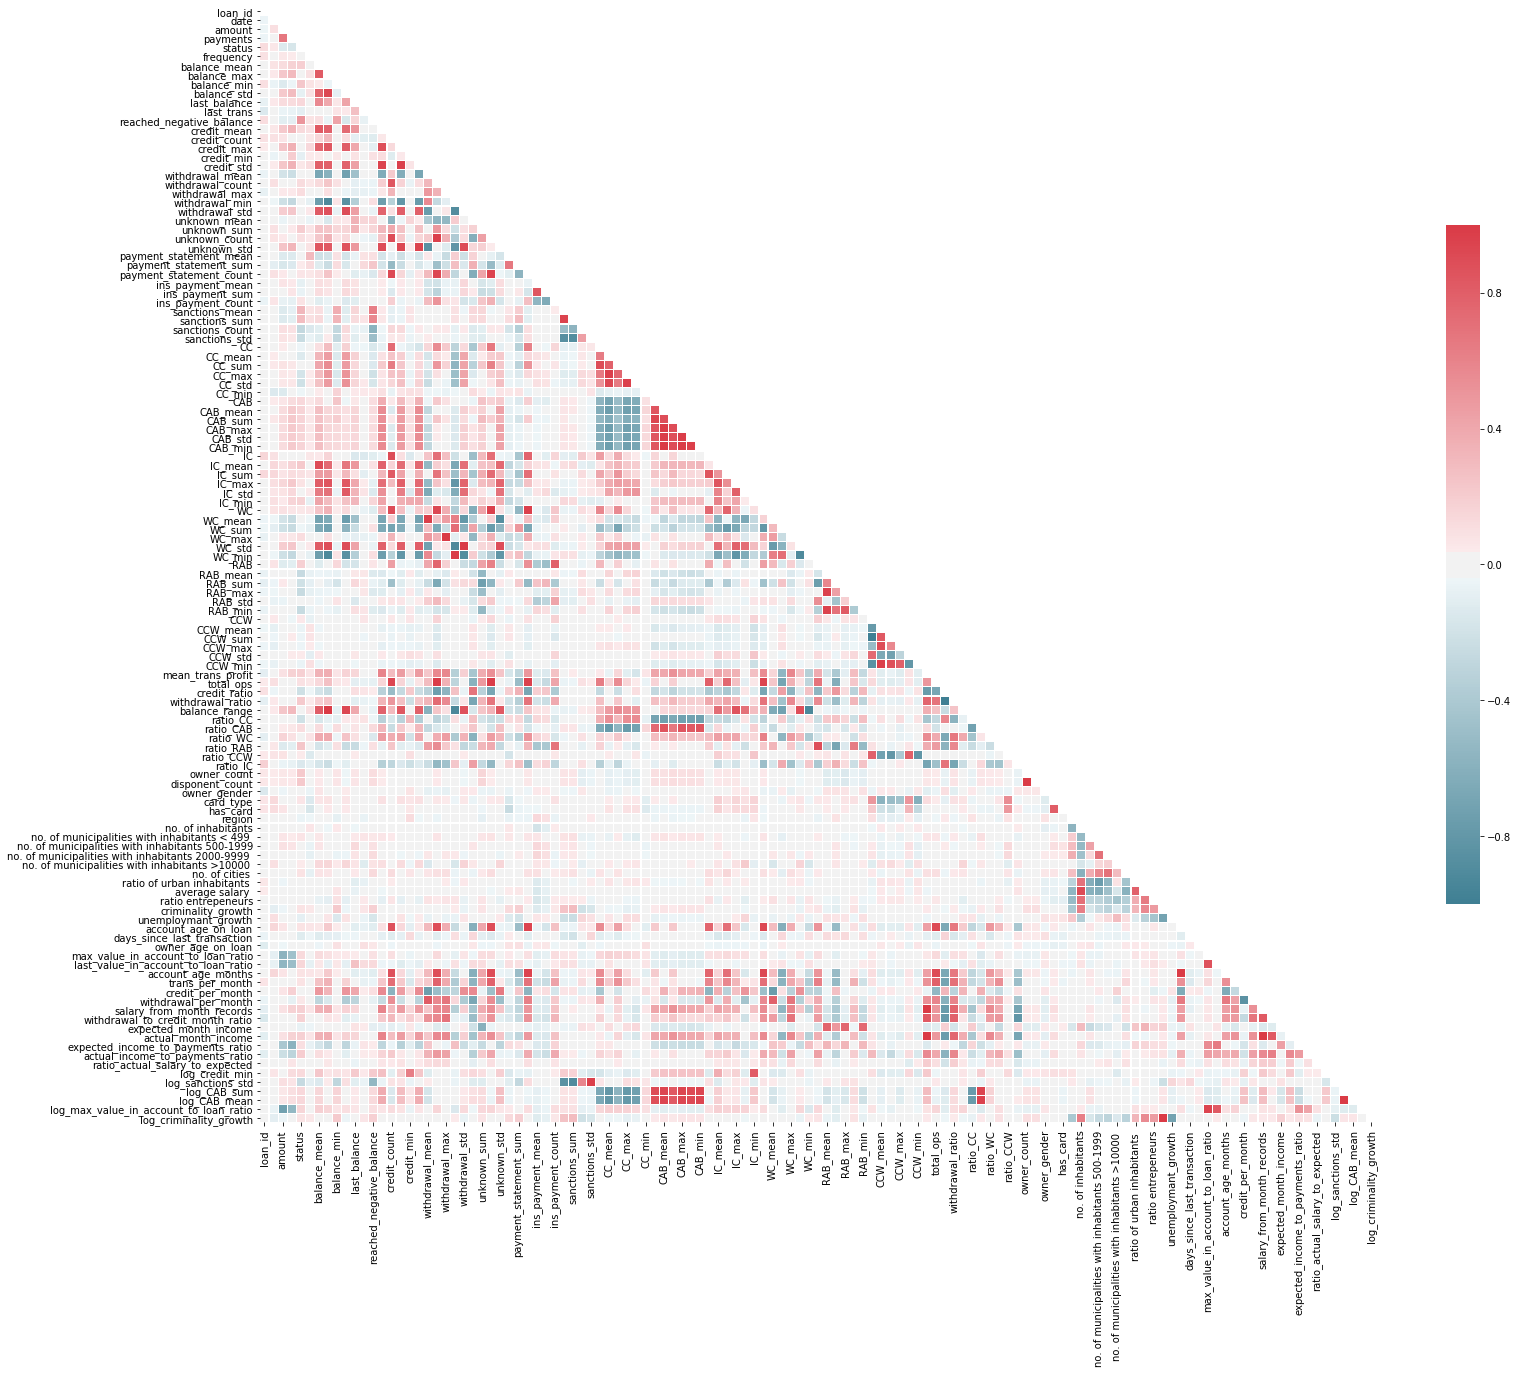

 >>> Table before heavy feature selection:


,loan_id,date,amount,payments,frequency,balance_mean,balance_max,balance_min,balance_std,last_balance,last_trans,reached_negative_balance,credit_mean,credit_count,credit_max,credit_min,credit_std,withdrawal_mean,withdrawal_count,withdrawal_max,withdrawal_min,withdrawal_std,unknown_mean,unknown_sum,unknown_count,unknown_std,payment_statement_mean,payment_statement_sum,payment_statement_count,ins_payment_mean,ins_payment_sum,ins_payment_count,sanctions_mean,sanctions_sum,sanctions_count,sanctions_std,CC,CC_mean,CC_sum,CC_max,CC_std,CC_min,CAB,CAB_mean,CAB_sum,CAB_max,CAB_std,CAB_min,IC,IC_mean,IC_sum,IC_max,IC_std,IC_min,WC,WC_mean,WC_sum,WC_max,WC_std,WC_min,RAB,RAB_mean,RAB_sum,RAB_max,RAB_std,RAB_min,CCW,CCW_mean,CCW_sum,CCW_max,CCW_std,CCW_min,mean_trans_profit,credit_ratio,withdrawal_ratio,balance_range,ratio_CC,ratio_CAB,ratio_WC,ratio_RAB,ratio_CCW,ratio_IC,owner_count,owner_gender,card_type,has_card,region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,ratio entrepeneurs,criminality_growth,unemploymant_growth,account_age_on_loan,days_since_last_transaction,owner_age_on_loan,max_value_in_account_to_loan_ratio,last_value_in_account_to_loan_ratio,account_age_months,trans_per_month,credit_per_month,withdrawal_per_month,salary_from_month_records,withdrawal_to_credit_month_ratio,expected_month_income,actual_month_income,expected_income_to_payments_ratio,actual_income_to_payments_ratio,ratio_actual_salary_to_expected,log_credit_min,log_sanctions_std,log_CAB_sum,log_CAB_mean,log_max_value_in_account_to_loan_ratio,log_criminality_growth,status
0,5314,741830400000000000,96396,8033,2,12250.000000,20100.0,1100.0,8330.866301,20100.0,3300.0,1.0,5025.000000,4,9900.0,1100.0,3774.806838,0.000000,0.0,0.0,0.0,0.000000,5025.000000,20100.0,4,3774.806838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,5025.000000,20100.0,9900.0,3774.806838,1100.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5025.000000,1.000000,0.000000,19000.0,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,1,1,-1.0,-1.0,7,94812,15,13,8,2,10,0.818,9650,0.100,-0.001909,0.29,105,15,45.986301,0.208515,0.208515,3.500000,1.142857,1435.714286,0.000000,5025.000000,0.000000,804.166667,5025.000000,0.100108,0.625545,6.248705,7.003247,0.0,0.000000,0.000000,0.113178,0.034255,-1
1,5316,742348800000000000,165960,4610,1,52083.859459,120512.8,700.0,29122.059454,52208.9,-3419.0,1.0,13523.158824,17,36574.0,2.9,13998.092225,-8884.240000,20.0,-14.6,-54300.0,14074.800608,2608.833333,62612.0,24,22249.103350,-14.6,-43.8,3.0,-956.0,-2868.0,3.0,0.0,0.0,0.0,0.0,12,19087.583333,229051.0,36574.0,13044.711945,700.0,0.0,0.000000,0.0,0.0,0.000000,0.0,5.0,168.540000,842.7,303.4,114.790213,2.9,12.0,-13018.816667,-156225.8,-14.6,17151.944816,-54300.0,8.0,-2682.375000,-21459.0,-956.0,1462.736373,-4167.0,0.0,0.0,0.0,0.0,0.0,0.0,4638.918824,0.459459,0.540541,119812.8,0.324324,0.000000,0.324324,0.216216,0.0,0.135135,1,0,-1.0,-1.0,2,112709,48,20,7,3,10,0.735,8369,0.117,-0.002094,0.52,148,2,24.986301,0.726156,0.314587,4.933333,7.500000,2741.180843,-1800.859459,4638.918824,-0.656965,350.166667,4291.668824,0.075958,0.930948,12.256075,1.131402,0.0,0.000000,0.000000,0.493154,0.034077,1
2,6863,743817600000000000,127080,2118,1,30060.954167,49590.4,800.0,11520.184451,20272.8,-12000.0,1.0,5009.733333,15,19065.0,48.6,6801.234716,-6097.000000,9.0,-66.0,-14800.0,5390.565972,1966.714286,27534.0,14,10647.755108,0.0,0.0,0.0,-66.0,-66.0,1.0,0.0,0.0,0.0,0.0,2,2250.000000,4500.0,3700.0,2050.609665,800.0,5.0,13981.000000,69905.0,19065.0,2842.042399,12710.0,8.0,92.625000,741.0,139.8,32.231872,48.6,6.0,-7733.333333,-46400.0,-1700.0,5385.041009,-14800.0,3.0,-2824.333333,-8473.0,-66.0,4431.462324,-7936.0,0.0,0.0,0.0

 > And the respective correlations


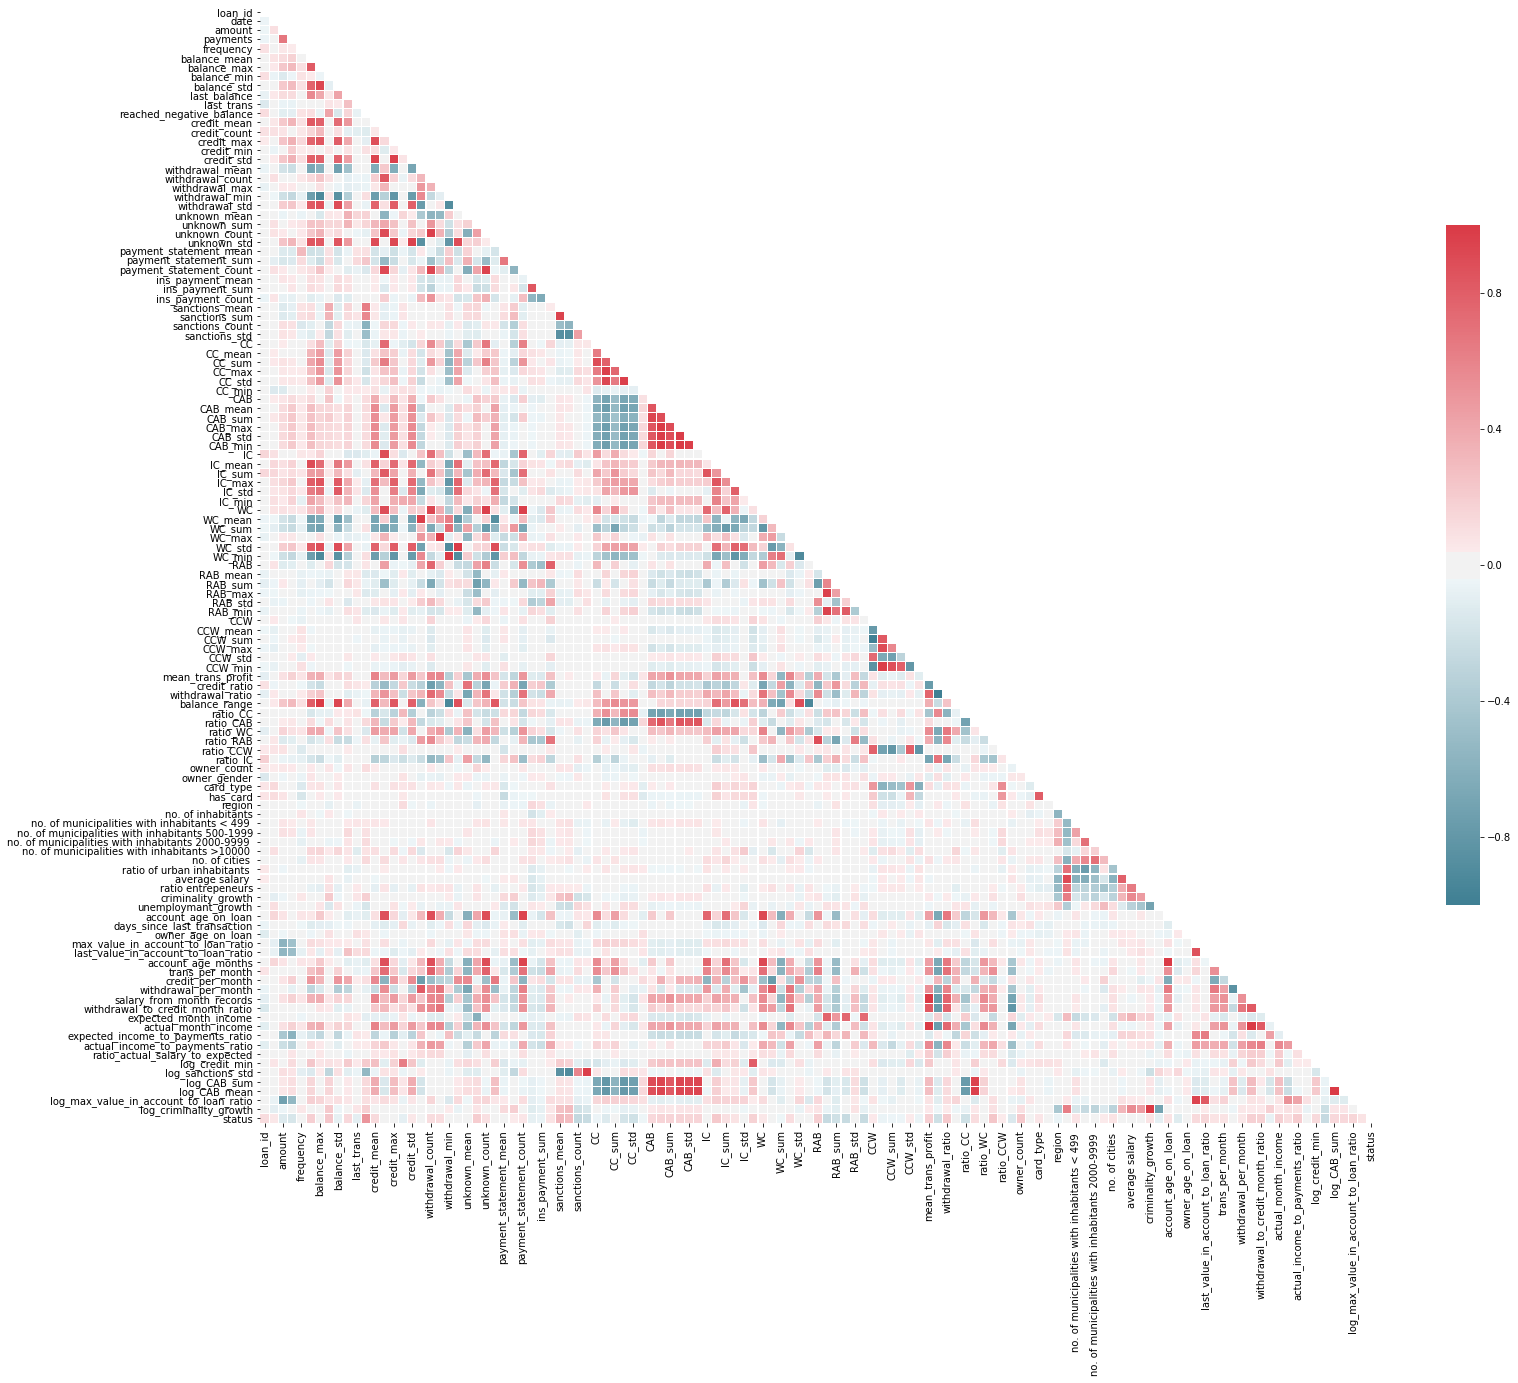

 > And the respective histograms for the given features


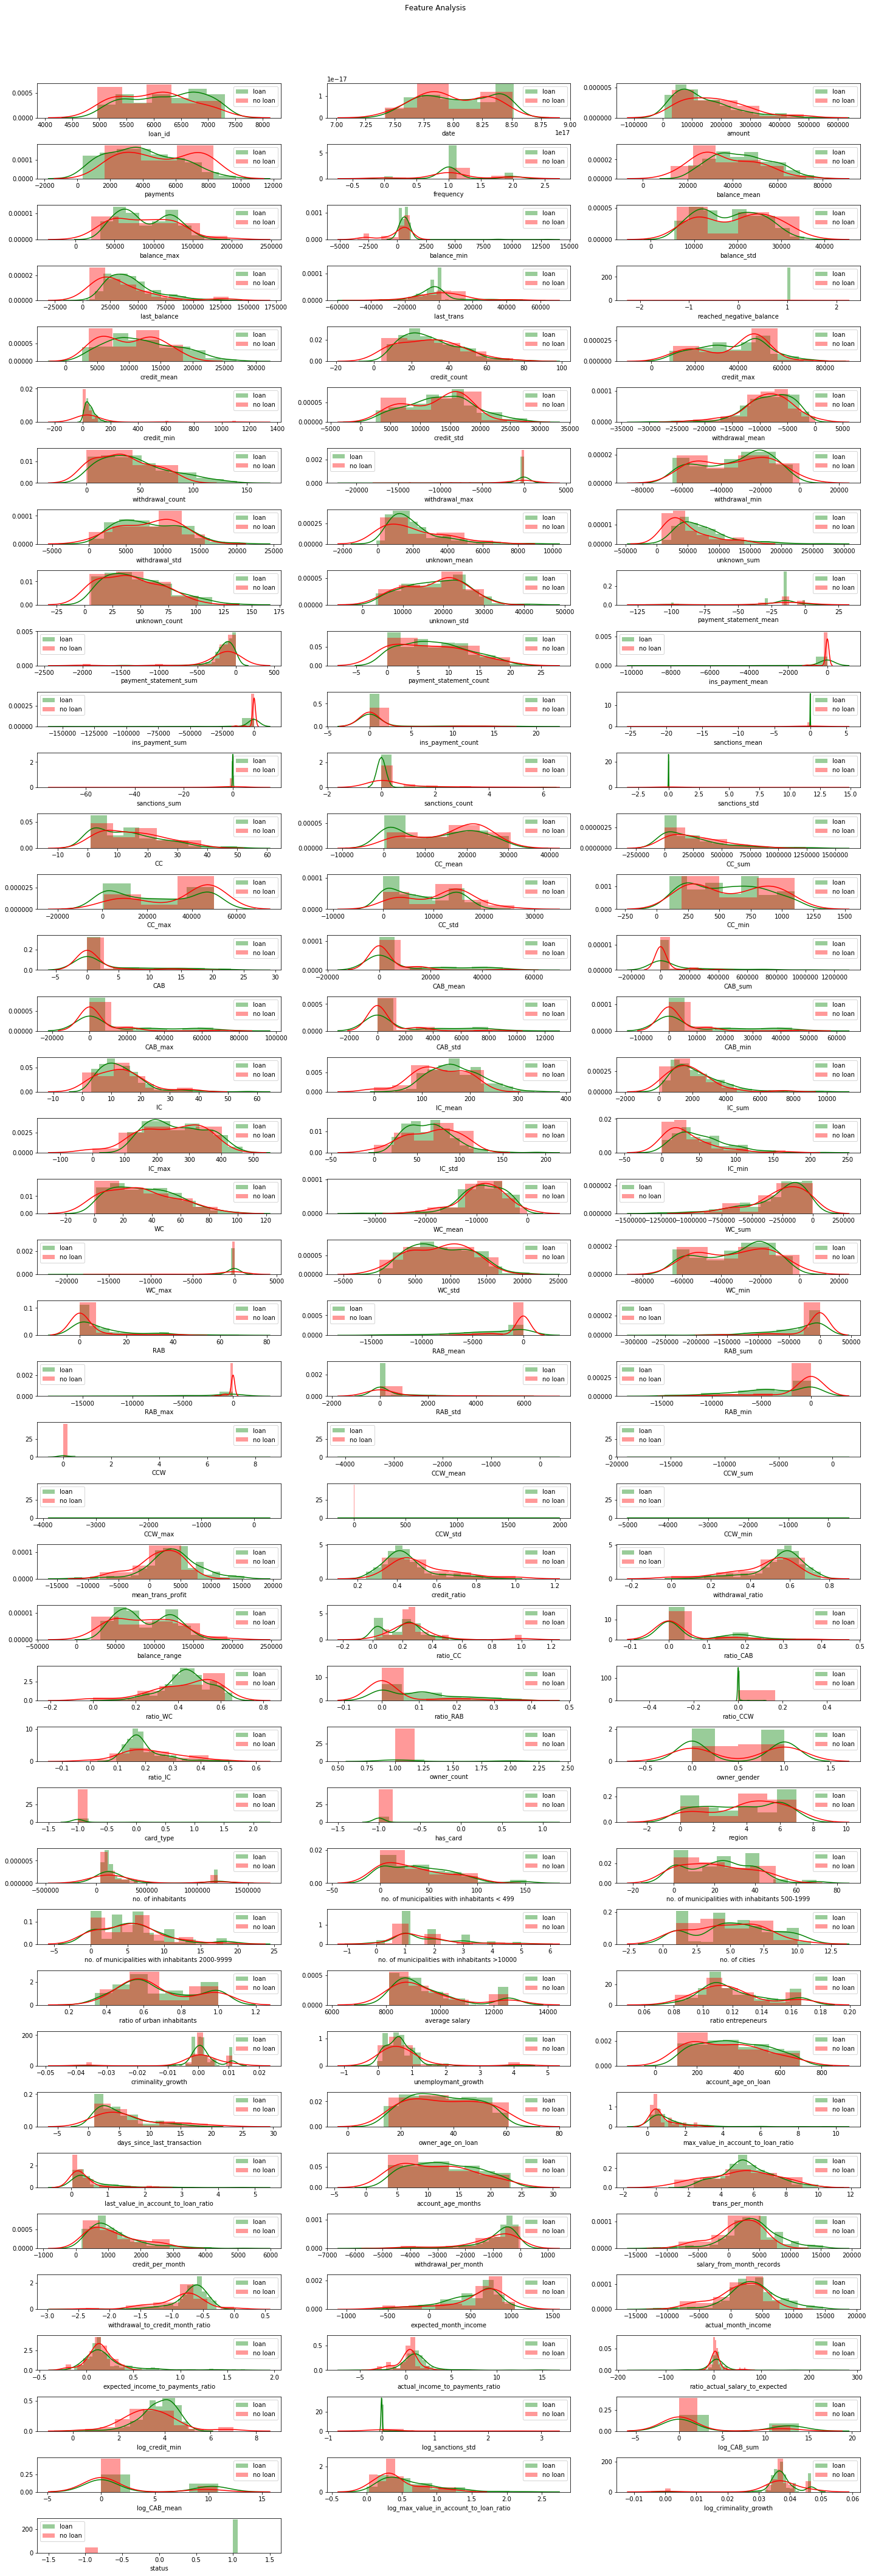

 > Correlation between status and other features


,loan_id,date,amount,payments,frequency,balance_mean,balance_max,balance_min,balance_std,last_balance,last_trans,reached_negative_balance,credit_mean,credit_count,credit_max,credit_min,credit_std,withdrawal_mean,withdrawal_count,withdrawal_max,withdrawal_min,withdrawal_std,unknown_mean,unknown_sum,unknown_count,unknown_std,payment_statement_mean,payment_statement_sum,payment_statement_count,ins_payment_mean,ins_payment_sum,ins_payment_count,sanctions_mean,sanctions_sum,sanctions_count,sanctions_std,CC,CC_mean,CC_sum,CC_max,CC_std,CC_min,CAB,CAB_mean,CAB_sum,CAB_max,CAB_std,CAB_min,IC,IC_mean,IC_sum,IC_max,IC_std,IC_min,WC,WC_mean,WC_sum,WC_max,WC_std,WC_min,RAB,RAB_mean,RAB_sum,RAB_max,RAB_std,RAB_min,CCW,CCW_mean,CCW_sum,CCW_max,CCW_std,CCW_min,mean_trans_profit,credit_ratio,withdrawal_ratio,balance_range,ratio_CC,ratio_CAB,ratio_WC,ratio_RAB,ratio_CCW,ratio_IC,owner_count,owner_gender,card_type,has_card,region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,ratio entrepeneurs,criminality_growth,unemploymant_growth,account_age_on_loan,days_since_last_transaction,owner_age_on_loan,max_value_in_account_to_loan_ratio,last_value_in_account_to_loan_ratio,account_age_months,trans_per_month,credit_per_month,withdrawal_per_month,salary_from_month_records,withdrawal_to_credit_month_ratio,expected_month_income,actual_month_income,expected_income_to_payments_ratio,actual_income_to_payments_ratio,ratio_actual_salary_to_expected,log_credit_min,log_sanctions_std,log_CAB_sum,log_CAB_mean,log_max_value_in_account_to_loan_ratio,log_criminality_growth
status,0.121917,0.061623,-0.128237,-0.168436,-0.007298,0.193985,0.019865,0.226679,-0.083467,0.138842,-0.097729,0.502993,0.126995,0.019421,0.004996,-0.087856,0.058619,0.024413,0.122053,0.110761,-0.005278,0.003361,-0.000019,0.203096,0.094239,0.025466,-0.0139,0.043572,0.064005,-0.084695,-0.069294,0.079072,0.314902,0.286268,-0.274294,-0.24354,-0.051181,-0.125393,-0.03891,-0.179912,-0.204384,-0.043192,0.137795,0.162357,0.158309,0.160894,0.153084,0.162646,0.003842,0.22164,0.101174,0.08506,-0.025943,0.177928,0.058313,0.008803,-0.044506,0.109771,0.02563,-0.005278,0.182415,-0.264412,-0.203213,-0.254507,0.025839,-0.257403,0.048169,-0.057676,-0.049027,-0.049331,0.044266,-0.057826,0.185935,-0.217682,0.217682,0.012576,-0.204533,0.115595,0.036317,0.237998,0.043068,-0.145612,0.2199,-0.022487,0.067839,0.038804,-0.057627,-0.007891,0.074296,0.035389,0.029973,0.040206,0.082499,-0.011979,0.013187,0.036389,0.083834,-0.088705,0.078792,-0.122921,-0.028047,0.126908,0.146587,0.078792,0.08225,0.011567,0.055035,0.185935,0.175691,-0.071685,0.181182,0.105515,0.201175,0.019312,0.129048,-0.264577,0.135028,0.133555,0.150489,0.085023


 > The more relevant features - the ones with higher correlations to the status variable - are:


,balance_min,reached_negative_balance,unknown_sum,sanctions_mean,sanctions_sum,IC_mean,withdrawal_ratio,ratio_RAB,owner_count,actual_income_to_payments_ratio,sanctions_count,sanctions_std,CC_std,RAB_mean,RAB_sum,RAB_max,RAB_min,credit_ratio,ratio_CC,log_sanctions_std
status,0.226679,0.502993,0.203096,0.314902,0.286268,0.22164,0.217682,0.237998,0.2199,0.201175,-0.274294,-0.24354,-0.204384,-0.264412,-0.203213,-0.254507,-0.257403,-0.217682,-0.204533,-0.264577


 > Now as list for easy copy pasta:


Index(['balance_min', 'reached_negative_balance', 'unknown_sum',
       'sanctions_mean', 'sanctions_sum', 'IC_mean', 'withdrawal_ratio',
       'ratio_RAB', 'owner_count', 'actual_income_to_payments_ratio',
       'sanctions_count', 'sanctions_std', 'CC_std', 'RAB_mean', 'RAB_sum',
       'RAB_max', 'RAB_min', 'credit_ratio', 'ratio_CC', 'log_sanctions_std'],
      dtype='object')

 > And features chosen manually since we think them important:


[]

 >>> Table with manual selected features and features with high correlation:


,loan_id,balance_min,reached_negative_balance,unknown_sum,sanctions_mean,sanctions_sum,IC_mean,withdrawal_ratio,ratio_RAB,owner_count,actual_income_to_payments_ratio,sanctions_count,sanctions_std,CC_std,RAB_mean,RAB_sum,RAB_max,RAB_min,credit_ratio,ratio_CC,status
0,5314,1100.0,1.0,20100.0,0.0,0.0,0.000000,0.000000,0.000000,1,0.625545,0.0,0.0,3774.806838,0.000000,0.0,0.0,0.0,1.000000,1.000000,-1
1,5316,700.0,1.0,62612.0,0.0,0.0,168.540000,0.540541,0.216216,1,0.930948,0.0,0.0,13044.711945,-2682.375000,-21459.0,-956.0,-4167.0,0.459459,0.324324,1
2,6863,800.0,1.0,27534.0,0.0,0.0,92.625000,0.375000,0.125000,1,-0.825590,0.0,0.0,2050.609665,-2824.333333,-8473.0,-66.0,-7936.0,0.625000,0.083333,1
3,5325,1000.0,1.0,47508.0,0.0,0.0,160.360000,0.480000,0.080000,1,0.511625,0.0,0.0,2050.609665,-6994.000000,-13988.0,-6994.0,-6994.0,0.520000,0.080000,1
4,7240,600.0,1.0,40788.0,0.0,0.0,190.183333,0.518519,0.111111,1,0.959146,0.0,0.0,0.000000,-6584.666667,-19754.0,-756.0,-9499.0,0.481481,0.037037,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,6818,200.0,1.0,101122.0,0.0,0.0,145.472727,0.593023,0.209302,2,0.741067,0.0,0.0,6517.394689,-1709.000000,-61524.0,-831.0,-2587.0,0.406977,0.151163,1
324,5625,800.0,1.0,56990.0,0.0,0.0,223.050000,0.525424,0.000000,1,0.869667,0.0,0.0,13832.527973,0.000000,0.0,0.0,0.0,0.474576,0.271186,-1
325,6805,800.0,1.0,51200.0,0.0,0.0,114.216667,0.487179,0.153846,1,1.255062,0.0,0.0,9517.351233,-3387.500000,-20325.0,-2056.0,-4719.0,0.512821,0.205128,1
326,7233,1100.0,1.0,38211.0,0.0,0.0,206.068421,0.588710,0.000000,1,1.729203,0.0,0.0,14644.196076,0.000000,0.0,0.0,0.0,0.411290,0.258065,1


 > And the respective correlations


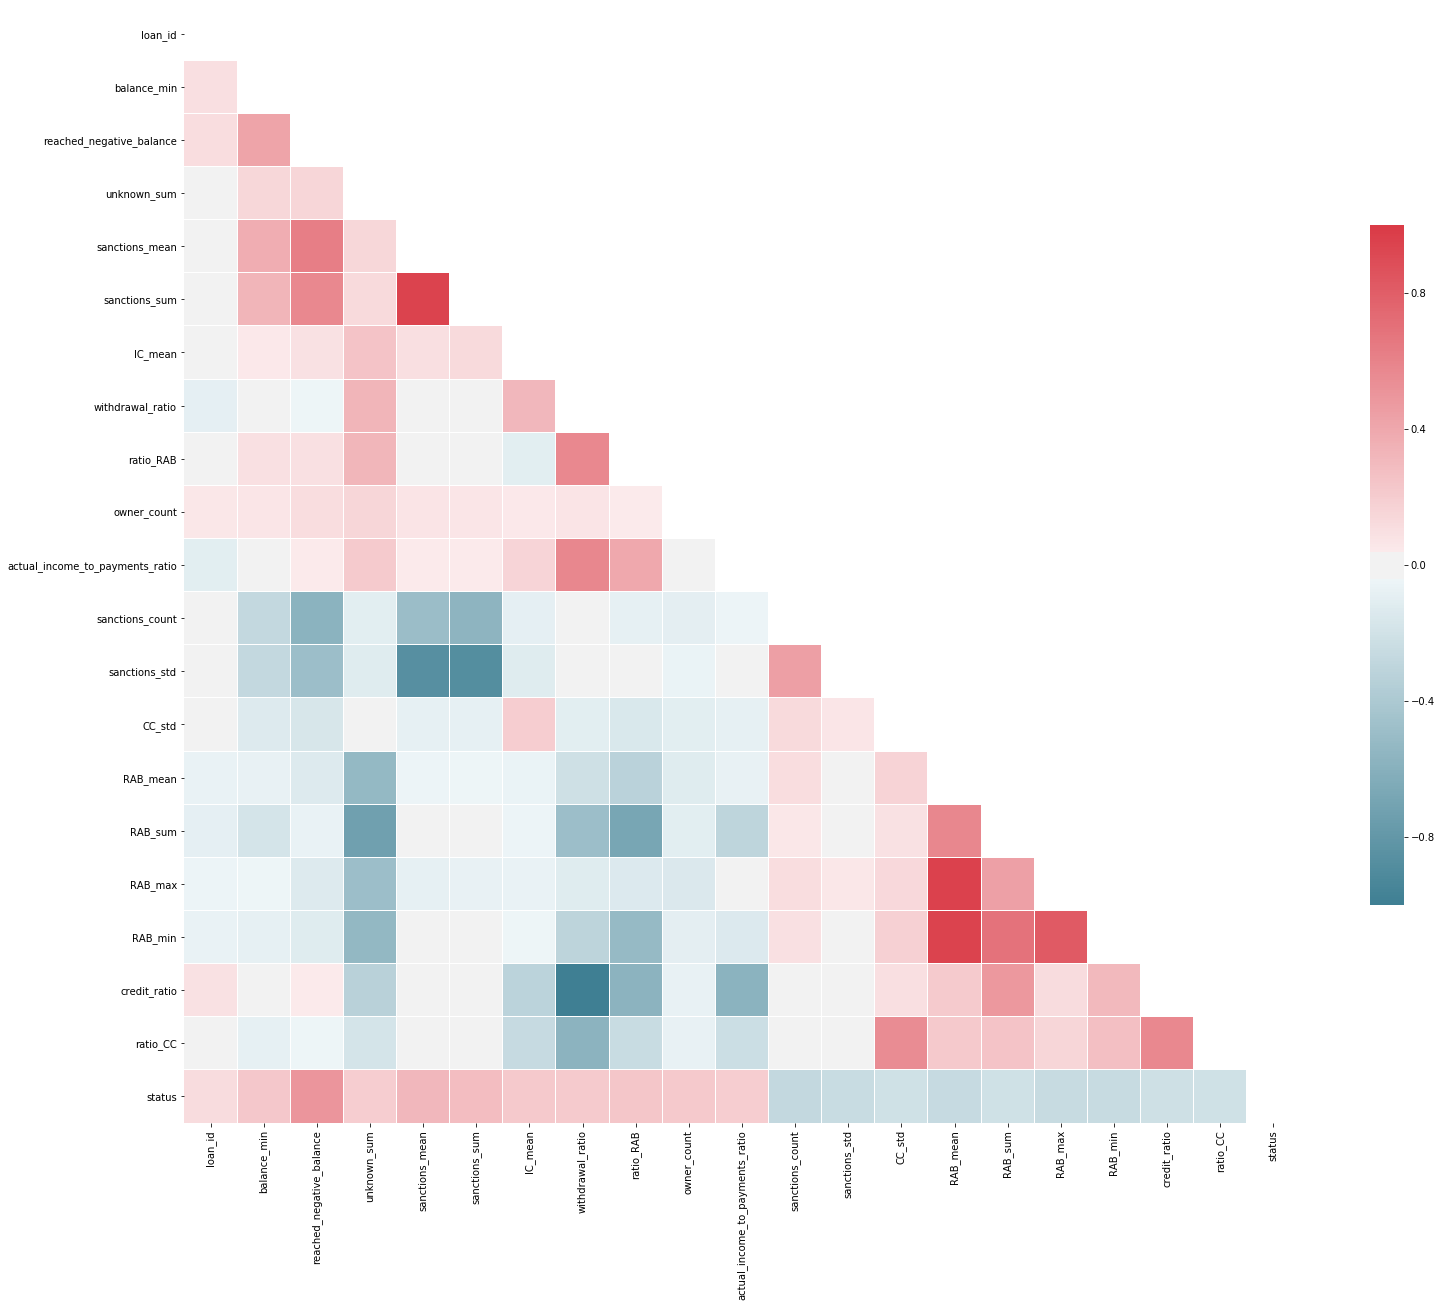

 >>> Final table that will serve as input to the model:


,loan_id,balance_min,reached_negative_balance,unknown_sum,sanctions_mean,sanctions_sum,IC_mean,withdrawal_ratio,ratio_RAB,owner_count,actual_income_to_payments_ratio,sanctions_count,CC_std,RAB_min,credit_ratio,ratio_CC,status
0,5314,1100.0,1.0,20100.0,0.0,0.0,0.000000,0.000000,0.000000,1,0.625545,0.0,3774.806838,0.0,1.000000,1.000000,-1
1,5316,700.0,1.0,62612.0,0.0,0.0,168.540000,0.540541,0.216216,1,0.930948,0.0,13044.711945,-4167.0,0.459459,0.324324,1
2,6863,800.0,1.0,27534.0,0.0,0.0,92.625000,0.375000,0.125000,1,-0.825590,0.0,2050.609665,-7936.0,0.625000,0.083333,1
3,5325,1000.0,1.0,47508.0,0.0,0.0,160.360000,0.480000,0.080000,1,0.511625,0.0,2050.609665,-6994.0,0.520000,0.080000,1
4,7240,600.0,1.0,40788.0,0.0,0.0,190.183333,0.518519,0.111111,1,0.959146,0.0,0.000000,-9499.0,0.481481,0.037037,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,6818,200.0,1.0,101122.0,0.0,0.0,145.472727,0.593023,0.209302,2,0.741067,0.0,6517.394689,-2587.0,0.406977,0.151163,1
324,5625,800.0,1.0,56990.0,0.0,0.0,223.050000,0.525424,0.000000,1,0.869667,0.0,13832.527973,0.0,0.474576,0.271186,-1
325,6805,800.0,1.0,51200.0,0.0,0.0,114.216667,0.487179,0.153846,1,1.255062,0.0,9517.351233,-4719.0,0.512821,0.205128,1
326,7233,1100.0,1.0,38211.0,0.0,0.0,206.068421,0.588710,0.000000,1,1.729203,0.0,14644.196076,0.0,0.411290,0.258065,1


 > And the respective correlations


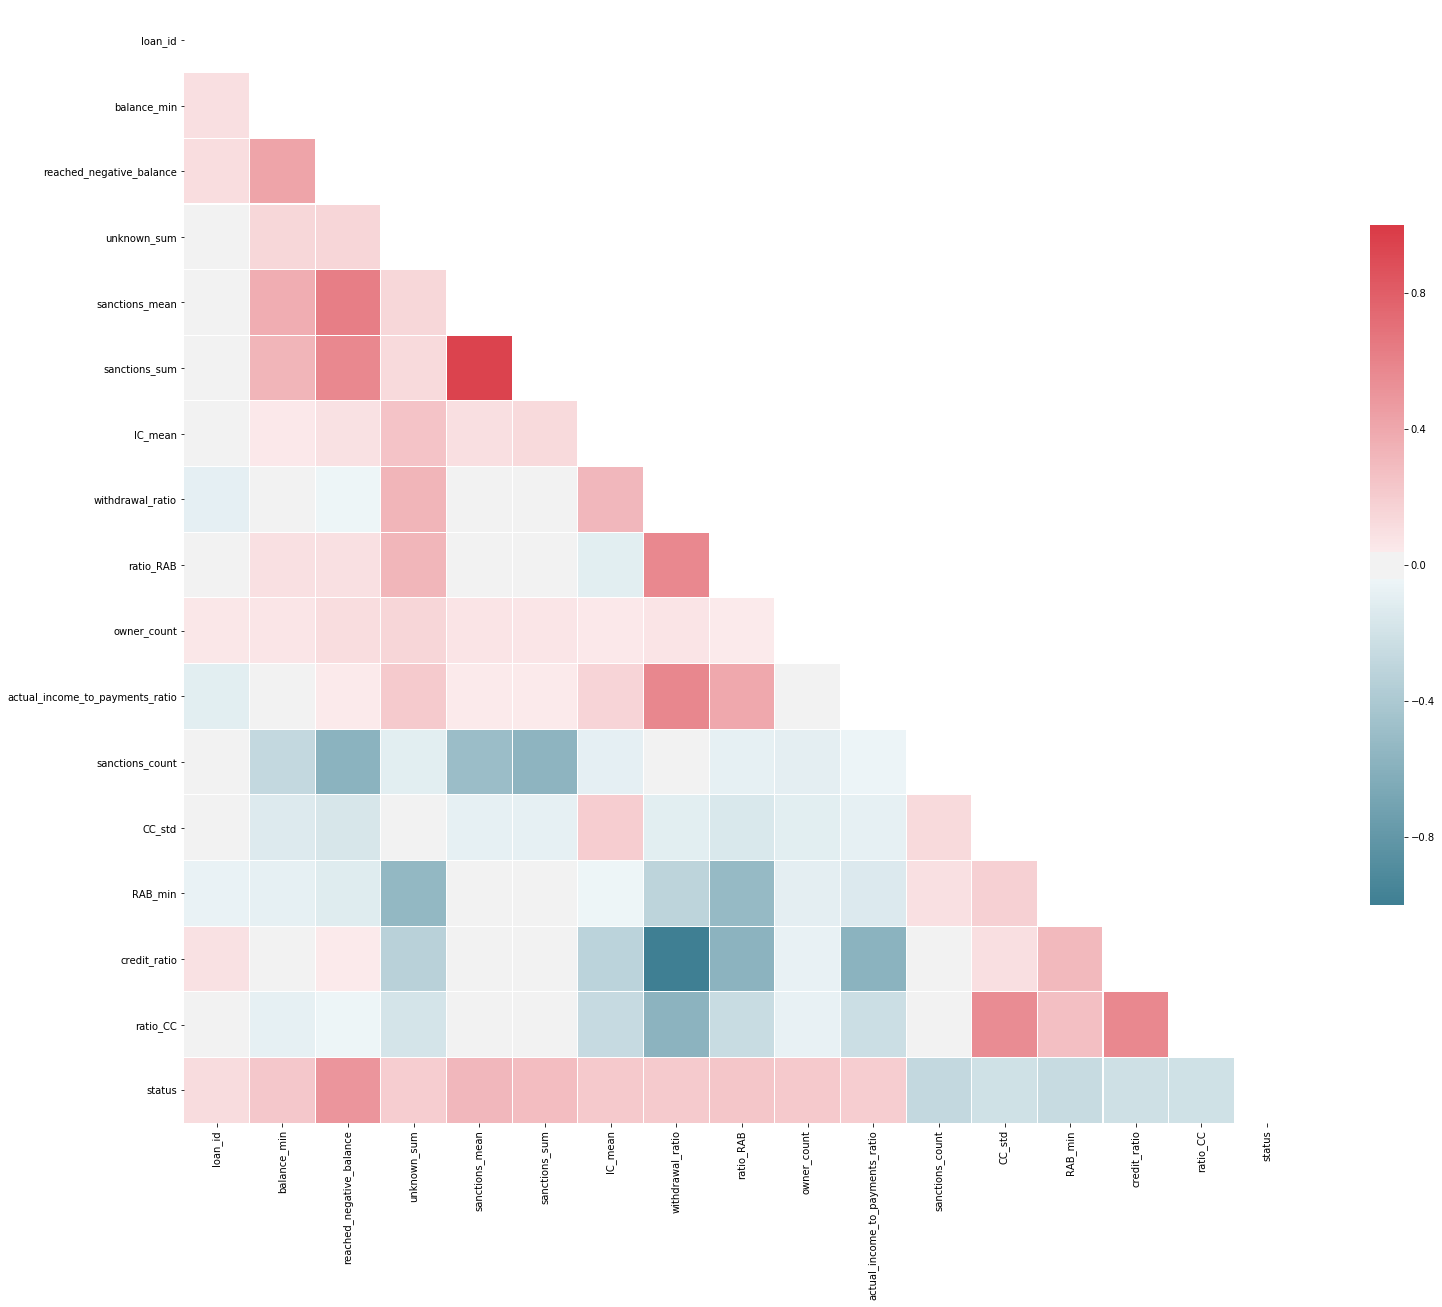

In [28]:
def compose_dataset(loan_df, account_df, disp_df, card_df, client_df, trans_df, demogra_df,
                    debug=False, pre_debug=False):
    '''Join the different tables and apply feature engineering'''

    # Pre processment of all the necessary tables
    processed_loan = process_loans(loan_df, pre_debug)
    processed_account = process_account(account_df, pre_debug)
    processed_trans = process_transactions(trans_df, pre_debug)
    processed_disp = process_dispostition(disp_df, pre_debug)
    processed_client = process_client(client_df, pre_debug)
    processed_card = process_card(card_df, pre_debug)
    processed_demogra = process_demographic(demogra_df, pre_debug)

    # Joining the different tables
    main_df = processed_loan.merge(processed_account.rename(columns={'date': 'account_creation_date'}),
                                   on='account_id', how='left')\
                            .merge(processed_trans,
                                   on='account_id', how='left')

    # Adding all bank demographic info has negative impact on model performance,
    # since we are feeding irrelevant features
    main_df = main_df.drop(['district_id'], axis=1)

    if debug:
        print(' > Joint table of loans, account, transaction:')
        display(main_df)
        
    ################################################

    df_disp_client_card = processed_disp.merge(processed_client,
                                              on='client_id', how='left')\
                                        .merge(processed_card,
                                              on='disp_id', how='left')
    if debug:
        print(' > Joint table of disposition, client & card:')
        display(df_disp_client_card)
        get_null_summary(df_disp_client_card)
    
    # Since there are so many, we disconsider the card date columns
    df_disp_client = df_disp_client_card.drop(['issued'], axis=1)
    df_disp_client = numerical_imputation(df_disp_client, -1)
    
    # Now we aggreggate the remaining data
    # TODO: not yet assure how to handle agg on birthdate and Gender -> using account and district id to get owner
    df_disp_client = df_disp_client.sort_values(by=['account_id', 'type_O'], ascending=[True, False])\
                                   .groupby(['account_id'])\
                                   .agg({
                                       'type_O': ['count'],
                                       'type_U': ['count'],
                                       'gender': get_first,
                                       'birth_date': get_first,
                                       'district_id': get_first,
                                       'type': get_first
                                   })\
                                   .reset_index()
    df_disp_client.columns= ['account_id', 'owner_count', 'disponent_count',
                             'owner_gender', 'owner_birthdate', 'district_id', 'card_type']
    df_disp_client['has_card'] = df_disp_client['card_type']
    df_disp_client.loc[df_disp_client["card_type"] > 0, "has_card"] = 1
    df_disp_client.loc[df_disp_client["card_type"] == 0, "has_card"] = -1
    
    
    if debug:
        print(' > Table after aggreggating data by account_id:')
        display(df_disp_client)
        
    # Now we join the district information regarding the owner
    df_secondary = df_disp_client.merge(processed_demogra, on='district_id')
    
    if debug:
        print(' > Table after joining with the demographics table:')
        display(df_secondary)
    
    ################################################
    
    # Joining the previously built two major tables
    df = main_df.merge(df_secondary, on='account_id')

    # Creating new columns using previous ones
    df['account_age_on_loan'] = (df['date'] - df['account_creation_date']).dt.days
    df['days_since_last_transaction'] = (df['date'] - df['last_trans_date']).dt.days
    df['owner_age_on_loan'] = (df['date'] - df['owner_birthdate']).dt.days / 365
    df["max_value_in_account_to_loan_ratio"] = df["balance_max"] / df["amount"]
    df["last_value_in_account_to_loan_ratio"] = df["last_balance"] / df["amount"]
    df["date"] = df["date"].astype(int)

    # Stats per month
    df['account_age_months'] = df['account_age_on_loan'] / 30
    df["trans_per_month"] = df['total_ops'] / df["account_age_months"]
    df['credit_per_month'] = df['credit_mean'] / df["account_age_months"]
    df['withdrawal_per_month'] = df['withdrawal_mean'] / df["account_age_months"]
    df['salary_from_month_records'] = df['credit_mean'] + df['withdrawal_mean']
    df['withdrawal_to_credit_month_ratio'] = df['withdrawal_per_month'] / df['credit_per_month']

    # Average salary, pension and household are anual- household value is negative
    df['expected_month_income'] = (df['average salary '] + df['household']) / 12
    df['actual_month_income'] = df['salary_from_month_records'] + (df['household'] / 12)
    df.loc[df["pension"] > 0, "expected_month_income"] = (df["pension"] + df['household']) / 12
    df.loc[df["pension"] > 0, "actual_month_income"] = df["actual_month_income"] + (df['pension'] / 12)
    df['expected_income_to_payments_ratio'] = df['expected_month_income'] / df['payments']
    df['actual_income_to_payments_ratio'] = df['actual_month_income'] / df['payments']
    df['ratio_actual_salary_to_expected'] = df['actual_month_income'] / df['expected_month_income']

    # Using Log transformation on skewed data
    df['log_credit_min'] = log_transform(df['credit_min'])
    df['log_sanctions_std'] = log_transform(df['sanctions_std']) 
    df['log_CAB_sum'] = log_transform(df['CAB_sum']) 
    df['log_CAB_mean'] = log_transform(df['CAB_mean'])
    df['log_max_value_in_account_to_loan_ratio'] = log_transform(df['max_value_in_account_to_loan_ratio'])
    df['log_criminality_growth'] = log_transform(df['criminality_growth'])

    # Showing some stats regarding the new features
    if pre_debug:
        print(' > Age of users when requesting a loan, in years')
        column_density_plot(df, 'owner_age_on_loan')
    
    # Dropping useless columns & normalizing others
    df = df.drop(['district_id', 'account_id', 'owner_birthdate', 'duration',
                 'pension', 'household'], axis=1)

    if debug:
        print(' > Obtained dataframe after joining the previous tables and doing some feature engineering over them')
        display(df)
        print(' > And the corresponding correlation matrix:')
        get_df_correlation(df, (25, 25))
        
    ###############################################

    # Feature selection
    df = df.drop(['account_creation_date', 'last_trans_date', 'total_ops', 'disponent_count'], axis=1)
    
    # Setting status as last column
    df =  df[[col for col in df if col not in ['status']] + ['status']]
    
    if debug: 
        print(' >>> Table before heavy feature selection:')
        display(df)
        print(' > And the respective correlations')
        get_df_correlation(df, (25, 25))
        print(' > And the respective histograms for the given features')
        get_features_histogram(df, (20, 60))
        
    # Creating filter based on correlations
    status_corr = df.corr().tail(1).drop(['status'], axis=1)
    if debug:
        print(' > Correlation between status and other features')
        display(status_corr)

    pos_status_corr = status_corr.loc[:, (status_corr > 0.2).any()]
    neg_status_corr = status_corr.loc[:, (status_corr < -0.2).any()]
    status_corr = pos_status_corr.merge(neg_status_corr, left_index=True, right_index=True)
    
    # Need to be hardcoded, otherwise they change on test data
    correlation_res_features = ['balance_min', 'reached_negative_balance', 'unknown_sum',
       'sanctions_mean', 'sanctions_sum', 'IC_mean', 'withdrawal_ratio',
       'ratio_RAB', 'owner_count', 'actual_income_to_payments_ratio',
       'sanctions_count', 'sanctions_std', 'CC_std', 'RAB_mean', 'RAB_sum',
       'RAB_max', 'RAB_min', 'credit_ratio', 'ratio_CC']
    
    manual_features = ['amount', 'payments', 'last_balance', 'log_max_value_in_account_to_loan_ratio']
    manual_features = []
    
    if debug:
        print(' > The more relevant features - the ones with higher correlations to the status variable - are:')
        display(status_corr)
        print(' > Now as list for easy copy pasta:')
        display(status_corr.columns)
        print(' > And features chosen manually since we think them important:')
        display(manual_features)

    # Filter indexes by correlations
    df = df[['loan_id'] + correlation_res_features + manual_features + ['status']]
    
    if debug:
        print(' >>> Table with manual selected features and features with high correlation:')
        display(df)
        print(' > And the respective correlations')
        get_df_correlation(df, (25, 25))
        
    # Dropping features with high correlation between themselves
    df = df.drop(['RAB_max', 'RAB_sum', 'RAB_mean', 'sanctions_std'], axis=1)
    
    # Manual selection from remaining
#    df = df[['loan_id', 'reached_negative_balance', 'last_balance', 'amount', 'payments',
#             'credit_per_month', 'withdrawal_per_month', 'sanctions_mean', 'status']]
    
    if debug:
        print(' >>> Final table that will serve as input to the model:')
        display(df)
        print(' > And the respective correlations')
        get_df_correlation(df, (25, 25))

    return df

dataset = compose_dataset(loan_df, account_df, disp_df, card_df, client_df,
                          trans_df, demogra_df, debug=True, pre_debug=False)

In [29]:
# Outputting the resultant table to a final csv
utils.write_df_to_csv(dataset, 'dataset', 'preprocessed_data.csv')

test_dataset = compose_dataset(loan_test_df, account_df, disp_df,
                               card_test_df, client_df, trans_test_df, demogra_df)
utils.write_df_to_csv(test_dataset, 'dataset', 'test_dataset.csv')